### VAE 

This notebook is a simple implementation of a Variational Autoencoder (VAE) using PyTorch. The VAE is a generative model that learns to encode and decode data. The model is trained on Anime Face dataset. 

In [8]:
import os
import time
import cv2
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras import backend as K
from IPython import display
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt

In [9]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [10]:
img_height, img_width = 256, 256
batch_size = 128

In [11]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(    
    "../data/anime_face/images",
    image_size=(img_height, img_width),
    batch_size=batch_size,
    label_mode=None,
)

Found 63565 files belonging to 1 classes.


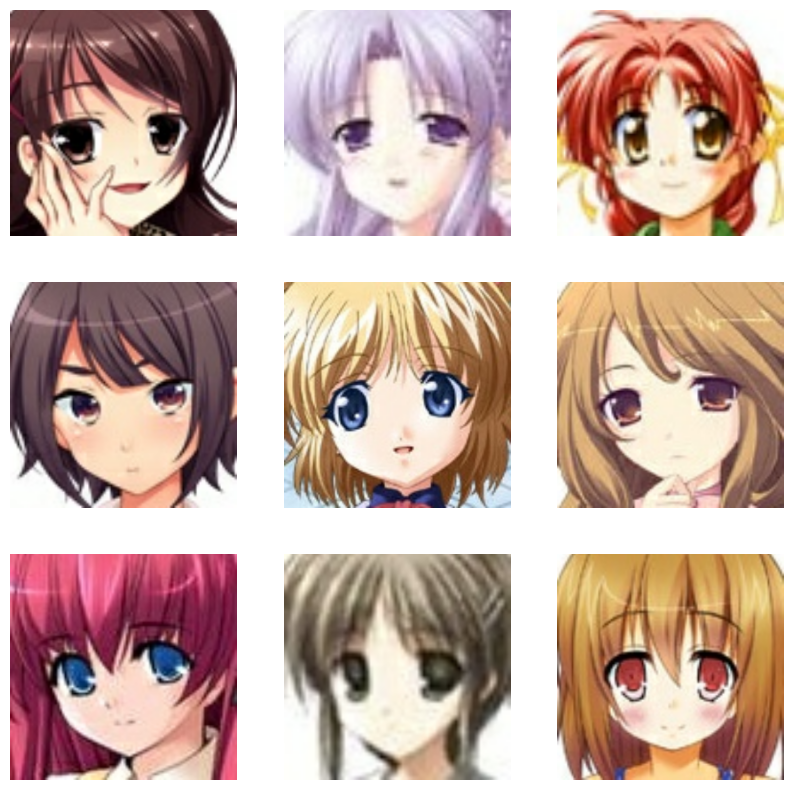

In [12]:
plt.figure(figsize=(10, 10))
for images in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.axis("off")